In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf 
import matplotlib.dates as mdates

In [2]:
dfxgboost= pd.read_csv('xgboost_results_dump.csv')
dfarima = pd.read_csv('arima_results_dump.csv')
#print(dfarima.head())
#print(dfxgboost.head())

In [3]:
dfxgboost.rename(columns={'Unnamed: 0':'date'},inplace = True)
dfarima.rename(columns={'Unnamed: 0':'date'},inplace = True)
dfsor = pd.merge(dfxgboost, dfarima, on = 'date', suffixes = ('_xgboost','_arima'))
dfsor['date'] = pd.to_datetime(dfsor['date'])
#print(dfsor.head())

In [4]:
if dfsor['y_train_xgboost'].equals(dfsor['y_train_arima']):
    dfsor.drop(columns=['y_train_arima'], inplace=True)
    dfsor.rename(columns={'y_train_xgboost': 'y_train'}, inplace=True)
print(dfsor.head())                                              

        date  y_train  y_train_pred_xgboost  y_dev_xgboost   
0 2015-01-01    135.0             136.21098            NaN  \
1 2015-01-02    187.0             184.00029            NaN   
2 2015-01-03    139.0             135.74527            NaN   
3 2015-01-04    141.0             134.56624            NaN   
4 2015-01-05    147.0             152.90903            NaN   

   y_dev_pred_xgboost  y_test_xgboost  y_test_pred_xgboost   
0                 NaN             NaN                  NaN  \
1                 NaN             NaN                  NaN   
2                 NaN             NaN                  NaN   
3                 NaN             NaN                  NaN   
4                 NaN             NaN                  NaN   

   y_train_pred_arima  y_dev_arima  y_dev_pred_arima  y_test_arima   
0          134.517581          NaN               NaN           NaN  \
1          134.936020          NaN               NaN           NaN   
2          156.980025          NaN          

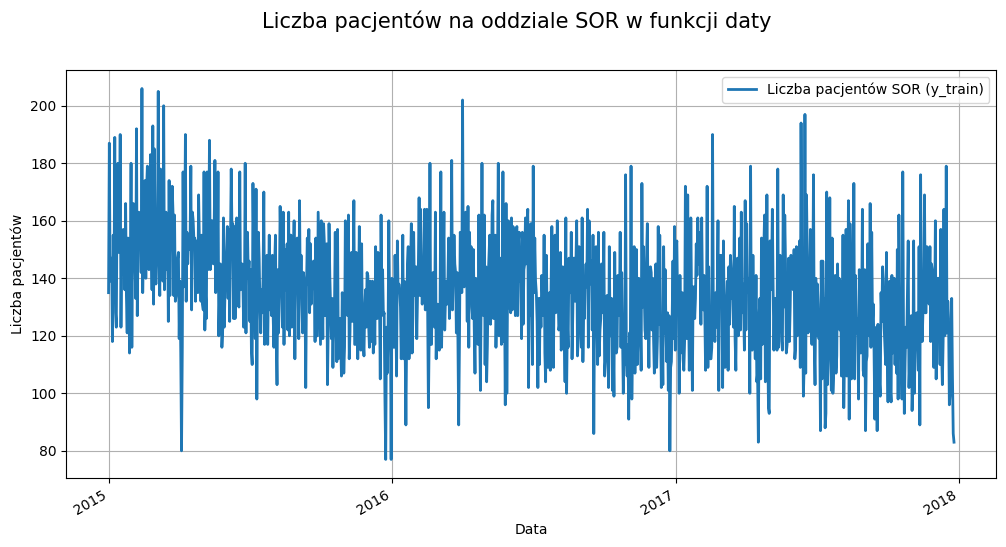

In [5]:
y_values = dfsor['y_train'].dropna()
dates = dfsor['date'][y_values.index]

date_locator = mdates.YearLocator(1)
date_formatter = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(dates, y_values, lw=2, label="Liczba pacjentów SOR (y_train)")
ax.xaxis.set_major_locator(date_locator)
ax.xaxis.set_major_formatter(date_formatter)
ax.set_ylabel("Liczba pacjentów")
ax.set_xlabel("Data")
ax.legend()
ax.grid(True)


fig.suptitle("Liczba pacjentów na oddziale SOR w funkcji daty", fontsize=15)
fig.autofmt_xdate()
#plt.show()

In [6]:
def plotMonthCounts(months, years, columns):
    filtered_data = dfsor[dfsor['date'].dt.month.isin(months)]
    filtered_data = filtered_data[filtered_data['date'].dt.year.isin(years)]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for column in columns:
        combined_data = []
        for year in years:
            data_for_year = filtered_data[filtered_data['date'].dt.year == year]
            combined_data.append(data_for_year[['date', column]])
        
        combined_data = pd.concat(combined_data)
        ax.plot(combined_data['date'], combined_data[column], lw=2, label=f"{column}")

    first_mondays = mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=4)  
    ax.xaxis.set_major_locator(first_mondays)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))

    ax.set_xlabel("Data")
    ax.set_ylabel("Liczba pacjentów")
    
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(labels))  
    ax.legend(handles[:len(columns)], unique_labels, title="Model")

    ax.grid(True)
    
    fig.suptitle(f"Liczba pacjentów w miesiącach {months} roku {years} dla modeli/u {columns}", fontsize=15)
    fig.autofmt_xdate()
    plt.show()


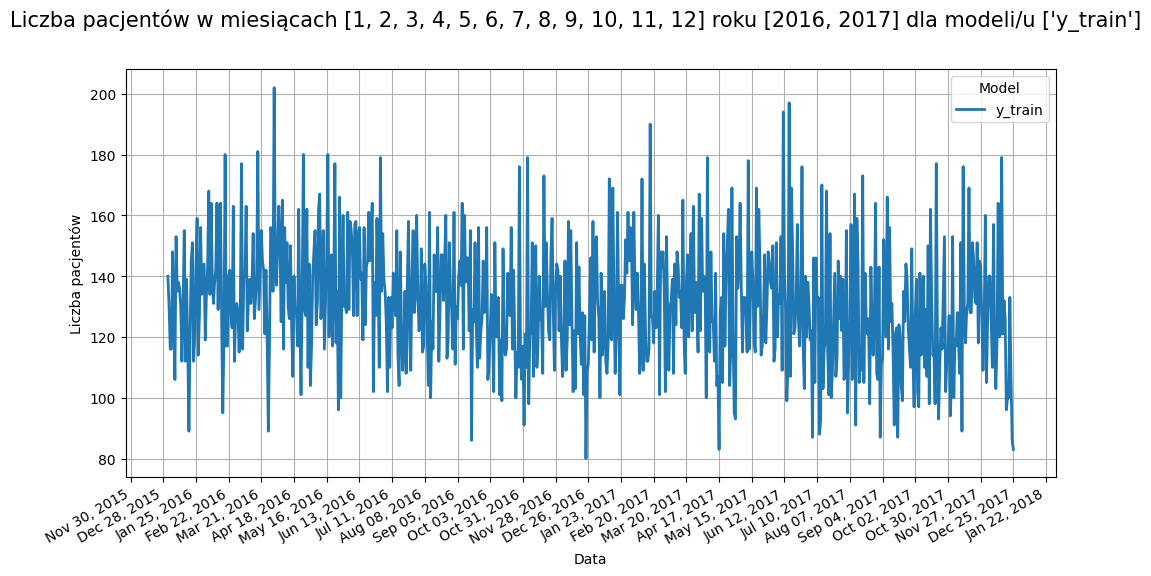

In [7]:
plotMonthCounts(months=list(range(1, 13)), years=[2016, 2017], columns=["y_train"])

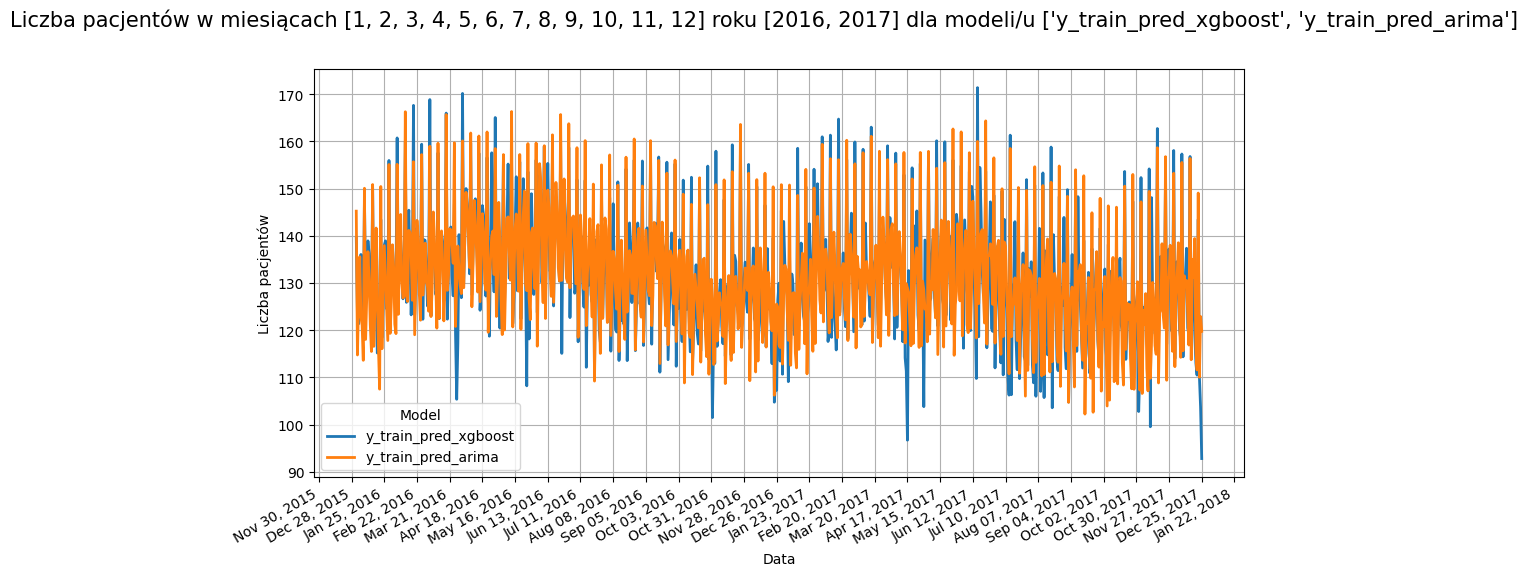

In [8]:
plotMonthCounts(months=list(range(1, 13)), years=[2016, 2017], columns=["y_train_pred_xgboost", "y_train_pred_arima"])

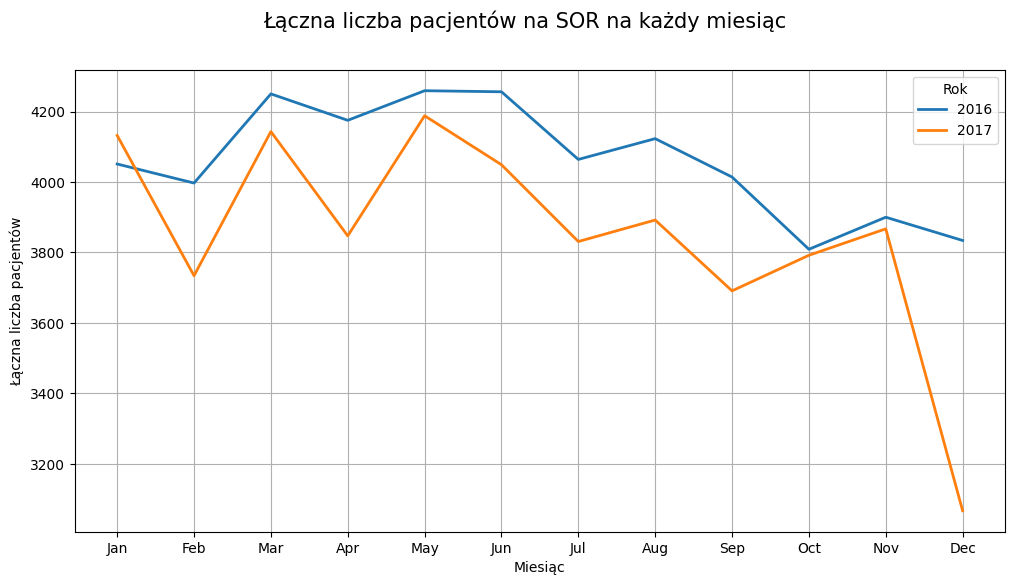

In [29]:
def plotMonthSumCounts(months, years, column, title="Łączna liczba pacjentów na SOR na każdy miesiąc"):
    filtered_data = dfsor[dfsor['date'].dt.month.isin(months)]
    filtered_data = filtered_data[filtered_data['date'].dt.year.isin(years)]
    
    monthly_totals = filtered_data.groupby(
        [filtered_data['date'].dt.year.rename('year'), 
         filtered_data['date'].dt.month.rename('month')]
    )[column].sum().reset_index()
    
    monthly_totals.rename(columns={column: 'total_patients'}, inplace=True)

    fig, ax = plt.subplots(figsize=(12, 6))
    
    for year in years:
        data_for_year = monthly_totals[monthly_totals['year'] == year]
        ax.plot(data_for_year['month'], data_for_year['total_patients'], lw=2, label=f"{year}")
        
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    ax.set_xlabel("Miesiąc")
    ax.set_ylabel("Łączna liczba pacjentów")
    ax.legend(title="Rok")
    ax.grid(True)
    fig.suptitle(title, fontsize=15)
    
    plt.show()

plotMonthSumCounts(months=list(range(1, 13)), years=[2016,2017], column="y_train")

In [65]:
def plotMonthSumCountsPeriod(period, years, column, title="Łączna liczba pacjentów na SOR w zadanym okresie"):
    filtered_data = dfsor[dfsor['date'].dt.year.isin(years)].copy()

    if 'd' in period:  
        try:
            window_size = int(period.replace('d', ''))  
        except ValueError:
            raise ValueError("Okres musi być w formacie np. '2d', '3d', '10d', itp.")
        
        filtered_data['rolling_sum'] = filtered_data[column].rolling(window=window_size).sum()
        period_data = filtered_data[['date', 'rolling_sum']].dropna().rename(
            columns={'rolling_sum': 'total_patients'})
    elif period == '1w':
        period_data = filtered_data.resample('W-MON', on='date')[column].sum().reset_index().rename(
            columns={column: 'total_patients'})
    elif period == '1m':
        period_data = filtered_data.resample('M', on='date')[column].sum().reset_index().rename(
            columns={column: 'total_patients'})
    elif period == '1y':
        period_data = filtered_data.resample('Y', on='date')[column].sum().reset_index().rename(
            columns={column: 'total_patients'})
    else:
        raise ValueError("Niepoprawny okres. Użyj 'Nd', '1w', '1m' lub '1y' (gdzie N to liczba dni).")

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(period_data['date'], period_data['total_patients'], lw=2, label=f"Suma ({period})")

    if 'd' in period:  
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    elif period == '1w':
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    elif period == '1m':
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    elif period == '1y':
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.set_xlabel("Data")
    ax.set_ylabel("Łączna liczba pacjentów")
    ax.legend(title="Okres")
    ax.grid(True)

    fig.suptitle(title, fontsize=15)
    fig.autofmt_xdate()

    plt.show()


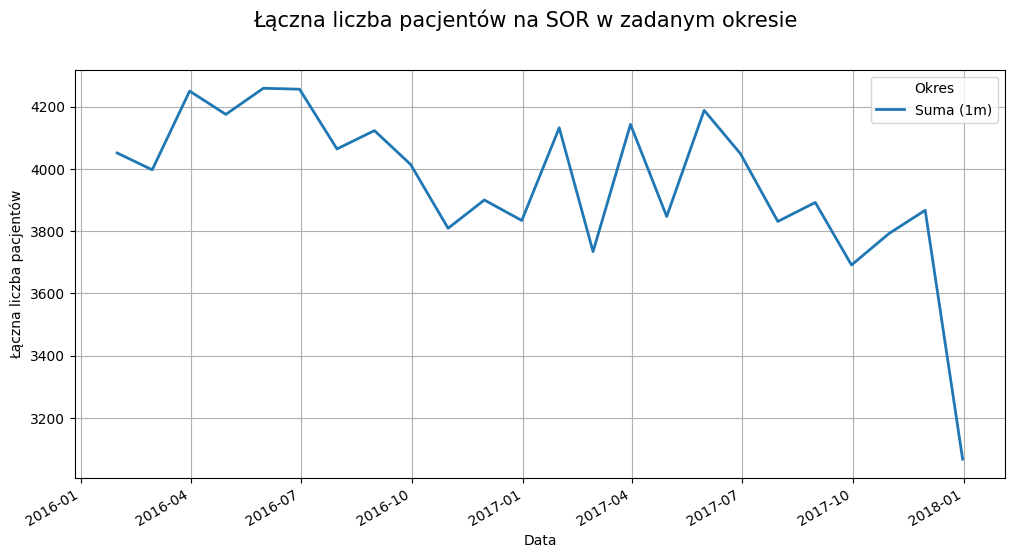

In [72]:
plotMonthSumCountsPeriod(period='1m', years=[2016, 2017],column="y_train")

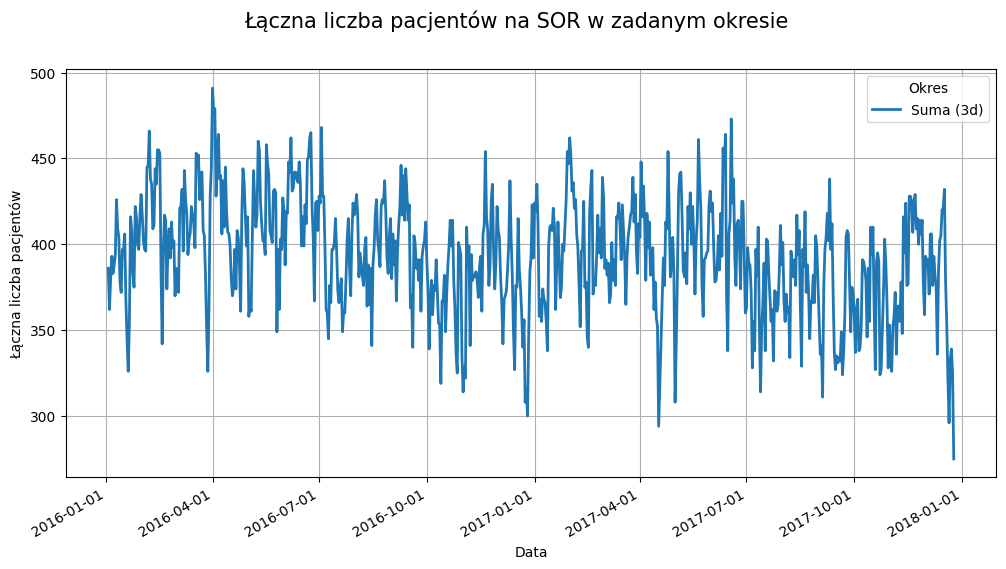

In [67]:
plotMonthSumCountsPeriod(period='3d', years=[2016, 2017],column="y_train")

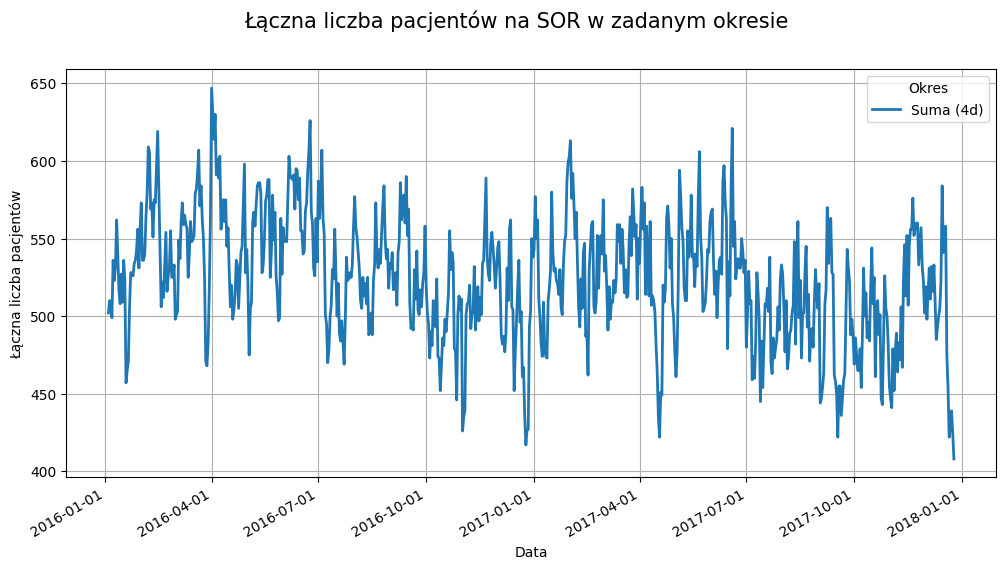

In [68]:
plotMonthSumCountsPeriod(period='4d', years=[2016, 2017],column="y_train")